In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
)
import itertools
from functools import partial
import pdb

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)

2023-03-20 19:05:51.018979: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 19:05:51.165032: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-20 19:05:51.676341: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-03-20 19:05:51.676403: W ten

In [2]:

protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)

/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


# Load best trained model

In [85]:
# (
#     (
#         mdm2_X_train,
#         mdm2_X_test,
#         mdm2_y_train,
#         mdm2_y_test,
#         mdm2_peptides_train,
#         mdm2_peptides_test,
#     ),
#     mdm2_results,
# ) = experiment.Experiment().run_adhoc_experiment(
#     X,
#     y_raw,
#     partial(rnn.SingleRegressionRNN_gelu),
#     optimizer=keras.optimizers.Adam(learning_rate=0.0005, weight_decay=0.5),
#     load_trained_model=False,
#     model_save_name=f"highly_regularized_model_only_er.h5",
#     other_datasets=[
#         peptides,
#     ],
#     batch_size=128,
#     num_epochs=5,
#     normalize=True,
# )

# mdm2_model = mdm2_results.trained_model
# mdm2_pred = mdm2_model(X)

# # model_save_name=f"grid_search_models/learning_rate({permutation['learning_rate']})_batch_size({permutation['batch_size']})_depth({permutation['depth']})_width({permutation['width']})_weightdecay({permutation['weight_decay']}).h5",


we are in here?
Epoch 1/5
206/206 [==============================] - 31s 144ms/step - loss: 0.9705 - multi_channel_mse: 0.9705 - lr: 5.0000e-04
Epoch 2/5
206/206 [==============================] - 28s 138ms/step - loss: 0.9457 - multi_channel_mse: 0.9457 - lr: 5.0000e-04
Epoch 3/5
206/206 [==============================] - 28s 137ms/step - loss: 0.9394 - multi_channel_mse: 0.9394 - lr: 5.0000e-04
Epoch 4/5
206/206 [==============================] - 29s 139ms/step - loss: 0.9366 - multi_channel_mse: 0.9366 - lr: 5.0000e-04
Epoch 5/5
206/206 [==============================] - 28s 138ms/step - loss: 0.9343 - multi_channel_mse: 0.9343 - lr: 5.0000e-04


In [93]:
(
    (
        mdm2_X_train,
        mdm2_X_test,
        mdm2_y_train,
        mdm2_y_test,
        mdm2_peptides_train,
        mdm2_peptides_test,
    ),
    mdm2_results,
) = experiment.Experiment().run_adhoc_experiment(
    X,
    y_raw,
    partial(
        rnn.ThreeChannelRegressionRNN_gelu, depth=9, width=128
    ),
    optimizer=keras.optimizers.Adam(
        learning_rate=0.0005, weight_decay=0.5
    ),
    load_trained_model=False,
    model_save_name=f"highly_regularized_model_only_er.h5",
    other_datasets=[
        peptides,
    ],
    batch_size=128,
    num_epochs=5,
    normalize=True,
)

mdm2_model = mdm2_results.trained_model
mdm2_pred = mdm2_model(X)

# model_save_name=f"grid_search_models/learning_rate({permutation['learning_rate']})_batch_size({permutation['batch_size']})_depth({permutation['depth']})_width({permutation['width']})_weightdecay({permutation['weight_decay']}).h5",


we are in here?
Epoch 1/5
206/206 [==============================] - 50s 239ms/step - loss: 0.8915 - multi_channel_mse: 0.9708 - fold_rmse: 0.9946 - p_value_rmse: 1.0264 - er_rmse: 0.8914 - lr: 5.0000e-04
Epoch 2/5
206/206 [==============================] - 49s 239ms/step - loss: 0.8297 - multi_channel_mse: 0.9658 - fold_rmse: 1.0181 - p_value_rmse: 1.0495 - er_rmse: 0.8297 - lr: 5.0000e-04
Epoch 3/5
206/206 [==============================] - 50s 244ms/step - loss: 0.8119 - multi_channel_mse: 0.9635 - fold_rmse: 1.0308 - p_value_rmse: 1.0479 - er_rmse: 0.8119 - lr: 5.0000e-04
Epoch 4/5
206/206 [==============================] - 51s 246ms/step - loss: 0.7970 - multi_channel_mse: 0.9596 - fold_rmse: 1.0319 - p_value_rmse: 1.0501 - er_rmse: 0.7970 - lr: 5.0000e-04
Epoch 5/5
206/206 [==============================] - 50s 244ms/step - loss: 0.7873 - multi_channel_mse: 0.9595 - fold_rmse: 1.0399 - p_value_rmse: 1.0513 - er_rmse: 0.7874 - lr: 5.0000e-04


In [22]:
# Calculate with dropout on...
pred_100_fold = np.array([mdm2_model(X, training=True) for _ in range(100)])
mean = np.mean(pred_100_fold, axis=0)
variance = np.std(pred_100_fold, axis=0)
print(mean)
print(variance)


[[ 1.7845438  -2.3828888  -1.765608  ]
 [ 1.5868176  -2.0994852  -1.5556314 ]
 [ 1.4428047  -1.8884317  -1.3942003 ]
 ...
 [-0.6664671   0.21709272 -0.01737598]
 [-0.63925916  0.2008051  -0.04750914]
 [-0.59591925  0.19431074 -0.03654537]]
[[0.3703419  0.49344578 0.42221117]
 [0.32278836 0.43482682 0.36632907]
 [0.33552986 0.43083498 0.3329255 ]
 ...
 [0.10240173 0.03301535 0.03392397]
 [0.12459823 0.04926784 0.04717378]
 [0.13348788 0.04634728 0.04217375]]


In [23]:
mdm2_pred = mean
mdm2_pred_uncertainty = variance

# Whats learned?

In [86]:
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

def fancy_plot_relations(x_idx, y_idx, mdm2_ordering, mdm2_pred=mdm2_pred, vals=['Pval','FC', 'ER']):
    fig = go.Figure([go.Scatter(
        x=mdm2_pred[:, x_idx],
        y=mdm2_pred[:, y_idx],
        text=peptides,
        mode="markers",
    )])
    fig.show()

def plot_relations(x_idx, y_idx, mdm2_ordering, mdm2_pred=mdm2_pred, vals=['Pval','FC', 'ER']):
    sns.jointplot(x=mdm2_pred[:, x_idx], y=mdm2_pred[:, y_idx]) # , kind='hex'
    plt.xlabel('Pred ' + vals[x_idx])
    plt.ylabel('Pred '+ vals[y_idx])
    plt.title('Predicted vals')

    top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-500)[-500]
    plt.scatter(
        x=mdm2_pred[:, x_idx][top_mdm2_mask],
        y=mdm2_pred[:, y_idx][top_mdm2_mask],
        color="red",
        alpha=0.01,
    )

def plot_relations_in_3D(x_idx, y_idx, uncertainty, mdm2_ordering, title='', mdm2_pred=mdm2_pred, vals=['Pval','FC', 'ER']):
    sns.set_style("whitegrid", {'axes.grid' : False})
    fig = plt.figure(figsize=(6,6))

    ax = Axes3D(fig) # Method 1

    top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-500)[-500]
    color = [(1, 0, 0, 1) if c else (0.8, 0.8, 0.8, 0.1) for c in top_mdm2_mask]
    ax.scatter(xs=mdm2_pred[:, x_idx], ys=mdm2_pred[:, y_idx], zs=uncertainty, c=color, marker='o')
    # fig = plt.figure(figsize=(12, 12))
    # ax = fig.add_subplot(projection='3d')
    # sns.jointplot(x=mdm2_pred[:, x_idx], y=mdm2_pred[:, y_idx]) # , kind='hex'
    ax.set_xlabel('Pred ' + vals[x_idx])
    ax.set_ylabel('Pred '+ vals[y_idx])
    ax.set_zlabel('Uncertainty')

    plt.title(title)

    ax.view_init(elev=10., azim=90)
    # top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-500)[-500]
    # ax.scatter(
    #     x=mdm2_pred[:, x_idx][top_mdm2_mask],
    #     y=mdm2_pred[:, y_idx][top_mdm2_mask],
    #     z=uncertainty[top_mdm2_mask],
    #     color="red",
    #     alpha=0.01,
    # )
    plt.show()

/tmp/ipykernel_16591/3602285768.py:32: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig) # Method 1
2023-03-20 20:31:32.705727: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

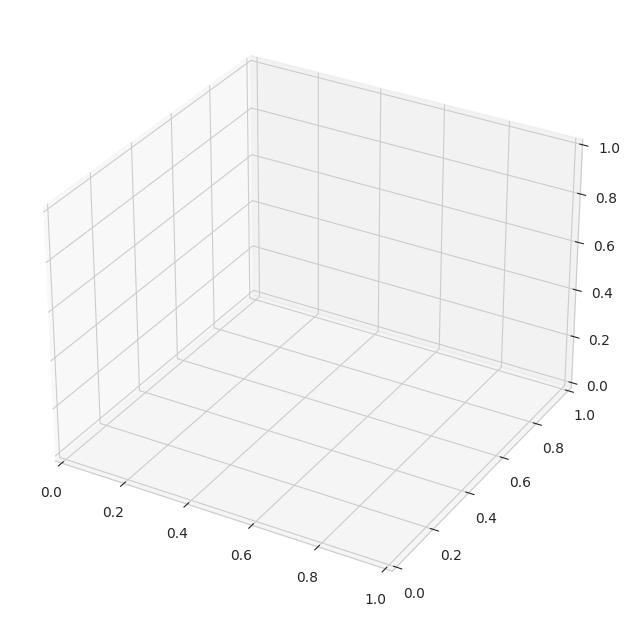

In [94]:
mdm2_ordering = []
for pred in mdm2_pred: #.numpy():
    mdm2_ordering.append(pred[2])# + pred[0] + pred[1])
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])

plot_relations_in_3D(1, 0, title='Predicted Hits Coloring', mdm2_ordering= mdm2_ordering, uncertainty=np.mean(variance, axis = 1))
plot_relations_in_3D(1, 0, title='Actual Hits Coloring', mdm2_ordering= hypothetical_best_mdm2_ordering, uncertainty=np.mean(variance, axis = 1))

In [119]:
mdm2_ordering = []
for pred in mdm2_pred.numpy():
    mdm2_ordering.append(pred[2])# + pred[0] + pred[1])
len(mdm2_ordering)
plot_relations(1, 0, mdm2_ordering=mdm2_ordering)


# sns.jointplot(x=mdm2_pred[:, 0], y=mdm2_pred[:, 1])
# mdm2_pred[:, 0]
mdm2_pred = mdm2_model(X)
mdm2_pred
sns.jointplot(x=mdm2_pred[:, 0], y=mdm2_pred[:, 1])

2023-03-20 20:36:40.603453: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

In [98]:


plot_relations(1, 0, mdm2_ordering=mdm2_ordering)

# this is just the hypothetical best ordering
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])
plot_relations(1, 0, mdm2_ordering=hypothetical_best_mdm2_ordering)
# fancy_plot_relations(1,0, mdm2_ordering=mdm2_ordering)


plot_relations(2, 0, mdm2_ordering=mdm2_ordering)
plot_relations(2, 0, mdm2_ordering=hypothetical_best_mdm2_ordering)
# fancy_plot_relations(2,0, mdm2_ordering=mdm2_ordering)


plot_relations(2, 1, mdm2_ordering=mdm2_ordering)
plot_relations(2, 1, mdm2_ordering=hypothetical_best_mdm2_ordering)
# fancy_plot_relations(2,1, mdm2_ordering=mdm2_ordering)

2023-03-20 20:32:26.935553: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at strided_slice_op.cc:105 : INVALID_ARGUMENT: slice index 1 of dimension 1 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 1 out of bounds. [Op:StridedSlice] name: strided_slice/

MDM2 area under curve:  299.8298523228591
normalized MDM2 area under curve:  0.5996597046457182


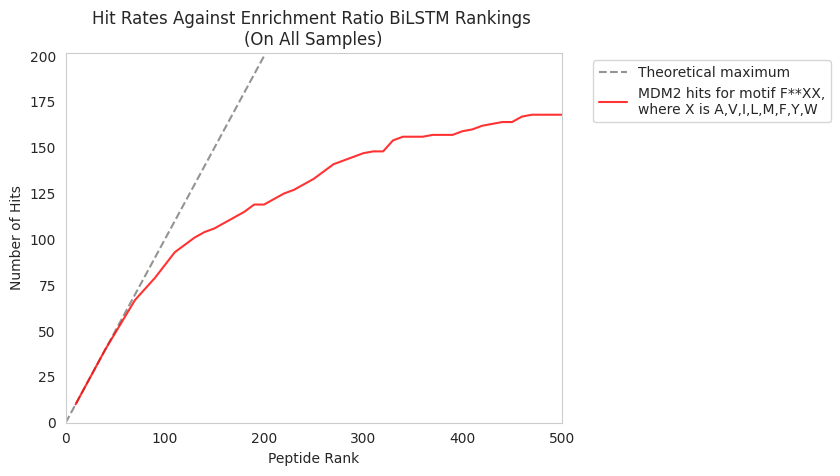

0.5996597046457182

In [120]:
plot_ratio_by_ranking(
    peptides=peptides,#mdm2_peptides_test,
    ca5_y_ranking=None,
    mdm2_y_ranking=mdm2_ordering,#np.squeeze(mdm2_only_er_results.y_pred), #mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On All Samples)",
    plot_theoretical_maximums=True,
    peptide_dataset_size=500,
)


In [83]:
# mdm2_ordering = []
# for pred in mdm2_pred: #.numpy():
#     mdm2_ordering.append(pred[2] + pred[0] + pred[1])


top_mdm2_mask = mdm2_ordering >= np.partition(mdm2_ordering, kth=-1000)[-1000]
# true_positives = set( pep for pep in peptides[top_mdm2_mask] if seq_contains_mdm2_motif(pep))
all_predicted = [peptides[idx] for idx, val in enumerate(top_mdm2_mask) if val]
true_positives = set( pep for pep in all_predicted if seq_contains_mdm2_motif(pep)) 

# this is just the hypothetical best ordering
all_positives = set( pep for pep in peptides if seq_contains_mdm2_motif(pep))
false_negatives = all_positives - all_positives.intersection(all_predicted)
print('true_positives: ', true_positives)
print('false_negatives: ', false_negatives)
print('true_positive lengths: ', set(len(pep) for pep in true_positives))
print('false_negatives lengths: ', set(len(pep) for pep in false_negatives))

true_positives:  {'AFSVWFWCS', 'ACFDIMYCK', 'AFCDWFWWS', 'AFCYLFWCD', 'AFCDWLWCC', 'ACFSKYFCH', 'ACVFDEWIC', 'AFCDWFWWC', 'ACSSFECFW', 'AFCDWFGCN', 'AFCDWFECF', 'AFSDWLWCS', 'AFCYWFVCN', 'AFCDWFFCS', 'AFWVWVWCS', 'AFCYLFLCS', 'ACSDFQCFW', 'ACVCFECFW', 'AFCAWFECN', 'AFCYWIWCS', 'ACWFEPIYC', 'ACYTFMCWW', 'AFCVWFECN', 'ACMSFLCWW', 'AFYDWFWCS', 'AFCDWFCCS', 'AFCDLFYCK', 'AFCDWVWCS', 'AFCDLVWCS', 'AFCDWFWYS', 'AFCDWFLCC', 'AFRDWFWCS', 'AFCDWFWRS', 'AFRDWFECN', 'ASKTFMCWW', 'AFSDWFWCS', 'AFCDWFACN', 'AFCDWMWCS', 'ACFWNWVKC', 'ACLTFMCWW', 'ACFFSAFCR', 'AFFFWFWCS', 'AGCFFECLF', 'AFFDWVWCS', 'ACSTFEFFW', 'AFCDWFWCP', 'AFCDWVECI', 'AFCYWLWCS', 'ACKIFMCWW', 'AFCDWLWCY', 'AFCGWFECN', 'AFCDWFECI', 'ACSTFECFW', 'AFCVLFWCC', 'AFCDLFWCA', 'ACETFMCWW', 'ACWSFECFW', 'AFCDWFVCI', 'AFCDWLLCS', 'AFCDWFDCN', 'AFCVWVWCC', 'ACKTFMYWW', 'AFCEWLWCS', 'AFCAWFWCS', 'AFCNWFECN', 'AFCAWFWWS', 'AFCDWFLCA', 'ACKTFMCWW', 'AFCDWYLCS', 'AFCDWFHCS', 'AFCDWLECN', 'AFCYWFWCY', 'AFCVWIWCS', 'AFCGFLCRL', 'AFCYWLLCS', 'AFCDWF

In [ ]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

er_lib = data_loading.read_data_and_preprocess(
    datafile=f"{protein_of_interest}_merged_ER.csv"
)
fc_pval_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
joint_lib = er_lib.merge(
    right=fc_pval_lib, right_on="Peptide", left_on="Peptide", suffixes=("x", "")
)
X, y_raw, peptides = data_loading.build_joint_dataset(
    joint_lib, protein_of_interest=protein_of_interest, other_protein=other_protein
)
(
    (
        mdm2_X_train,
        mdm2_X_test,
        mdm2_y_er_train,
        mdm2_y_er_test,
        mdm2_peptides_train,
        mdm2_peptides_test,
    ),
    mdm2_only_er_results,
) = experiment.Experiment().run_adhoc_experiment(
    X,
    y_raw[:, 2].reshape(-1,1),
    rnn.SingleRegressionRNN_gelu, #rnn.SingleChannelRegressionRNN, #rnn.ThreeChannelRegressionRNN,
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    load_trained_model=True,
    model_save_name="mdm_2_ER_only_with_no_cadherin_data_2.h5",#'mdm_2_ER_3.h5',
    other_datasets=[
        peptides,
    ],
    normalize=True
)
mdm2_er_model = mdm2_only_er_results.trained_model
only_er_volcano_mdm2_ordering = np.squeeze([pred_val for pred_val in mdm2_er_model(X)])
print(X.shape)
mdm2_ordering = only_er_volcano_mdm2_ordering



we are in here?


/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


OSError: No file or directory found at mdm_2_ER_only_with_no_cadherin_data_2.h5

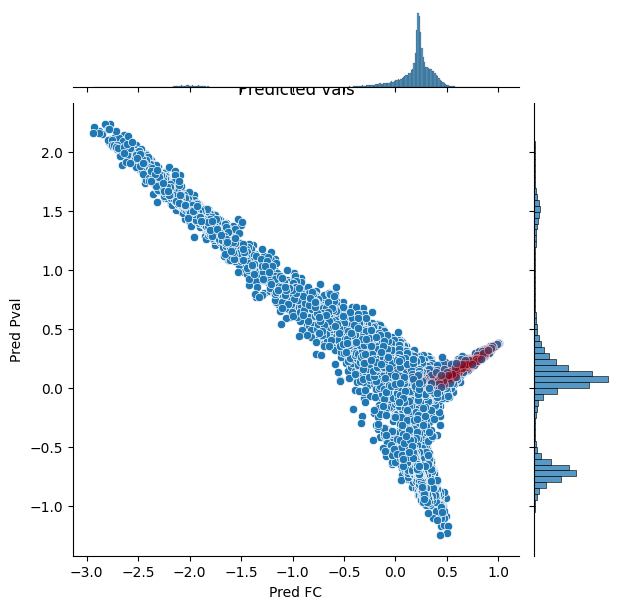

In [ ]:

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)

# this is just the hypothetical best ordering
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])
plot_relations(1, 0, mdm2_ordering=np.squeeze(mdm2_er_model(X).numpy()))